Terry Boo Chee Yee, Li Sheng | P2211194, P2309110 | DAAA/FT/2B/22 | Deep Learning CA2 - Part A (GAN)

<h1><Center>Generative Adverserial Network</Center></h1>

# Progression (Delete after finish with part A)

## Done

###### EDA
- Check for unique classes in the dataset
- Plotted sample images with it's label
- Plotted number of image in each class
- Check if there are images with contsant pixel values (image that appears completely uniform or monochromatic, lacking any discernible features, textures, or details)
- Class where the constant pixel images belong to
- Check for duplicated images
- Cleaned the dataset by removing the '-1' and use a bar graph to show the number of images in each class
###### Preprocessing
- Getting original, normalized and binarized versions of the images
- Data augmentation
- Enhancing Image using processing techniques
###### Modelling
- BASE DCGAN (Completed)
- DCGAN with stridded convolutions
- CGAN


## To do

- Duplicated images (Pixel Values are the same)
- Deal with black images in class '-1' (Done: Decided to drop them)
- Deal with contant pixel images
- Deal with mislabeled images

# Overview

# Table of contents

- [1. Background](#1)
- [2. Set Up](#2)
  - [2.1 Importing Libraries](#2.1)
  - [2.2 Loading the Dataset](#2.2)
- [3. Exploratory Data Analysis](#3)
  - [3.1 Shape of the Data](#3.1)
  - [3.2 Unique Classes in the Dataset](#3.1)
  - [3.3 Sample Images From Each Class](#3.2)
  - [3.4 Number of Images in Each Class](#3.4)
- [4. Data Cleaning](#4)
  - [4. Excluding Irrelevant Images](#4)
- [3. Data Preprocessing](#5)

# Background <a id = '1'></a>

__Task__

We are working on a project to create 260 small black-and-white images

__What are GANs__

Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

__Main components of GAN__

- Discriminator

The discriminator in a GAN is simply a classifier. It tries to distinguish real data from the data created by the generator. It could use any network architecture appropriate to the type of data it's classifying.

- Generator

The generator part of a GAN learns to create fake data by incorporating feedback from the discriminator. It learns to make the discriminator classify its output as real.

__How Gan works__

First, the generator creates samples from random noise inputs and feeds these generated samples into the discriminator. The discriminator then tries to classify whether each sample is real (from the actual data distribution) or generated (fake).

__If you are asked to generate images of a specific class, propose a way of doing it__

__If you are asked to generate coloured images instead of black-and-white ones, do you think it would be easier or harder to produce better quality results__

__What class(es) is/are relatively easier/harder to generate? Why?__

__References__

https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/

https://developers.google.com/machine-learning/gan/gan_structure

# Set Up <a id = '2'></a>

## Importing Libraries <a id = '2.1'></a>

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import random
import os
import shutil
import tensorflow as tf
import math
from PIL import Image
from collections import Counter

# Visualizations Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Utility  Libraries
from sklearn.utils import resample
from tensorflow.keras.utils import Sequence
import tensorflow.keras.utils as image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory

# Pre-Processing Libraries
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

# Model Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

#Layers Libraries
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose

#Callback Libraries
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Optimizer Libraries 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

# Evaluation Libraries
from sklearn.metrics import classification_report
from visualkeras import layered_view
from sklearn.metrics import confusion_matrix

# ignore warnings
import pickle
import warnings
warnings.filterwarnings("ignore")

## Loading the Dataset <a id = '2.2'></a>

In [2]:
# Load the CSV file into a DataFrame
df = pd.read_csv('emnist-letters-train.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Exploratory Data Analysis <a id = '3'></a>

## Shape of the Data <a id = '3.1'></a>

In [3]:
# Convert DataFrame to NumPy array
data = df.values
# Check the shape of the data
print("Shape of data array:", data.shape)

Shape of data array: (99040, 785)


## Unique pixel values in the dataset

In [4]:
# Extract pixel values (assuming they start from column index 1)
pixel_values = df.iloc[:, 1:].values.flatten()

# Get unique pixel values
unique_pixel_values = np.unique(pixel_values)

print("Unique Pixel Values:")
print(unique_pixel_values)

Unique Pixel Values:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 2

## Check if there are images with contsant pixel values

In [5]:
def is_constant_image(row):
    pixel_values = row.iloc[1:].values 
    # If the rest of the pixel values is the same as the first pixel value
    return np.all(pixel_values == pixel_values[0])

In [6]:
# Apply the function to each row and filter for constant pixel value rows
constant_images = df[df.apply(is_constant_image, axis=1)]

print(f"Number of constant pixel value images: {constant_images.shape[0]}")


# Retrieve unique class labels for constant pixel value images
unique_constant_pixel_class = np.unique(constant_images.iloc[:, 0].values)


print(f'Class labels for images with constant pixel values: {unique_constant_pixel_class}')

Number of constant pixel value images: 10240
Class labels for images with constant pixel values: [-1]


## Check for duplicated images

In [7]:
# Check for duplicated rows based on pixel values
duplicated_rows = df.duplicated(subset=df.columns[1:], keep=False)

# Filter the DataFrame to show duplicated rows
duplicated_images = df[duplicated_rows]

# Group the duplicated images together based on pixel values
grouped_duplicates = duplicated_images.groupby(list(df.columns[1:]), as_index=False).apply(lambda x: x.reset_index(drop=True))

grouped_duplicates

0    1    2    3    4    5    6    7    8    9    ...  775  776  777  \
0   0    -1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
    1    -1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
    2    -1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
    3    -1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
    4    -1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
257 35   -1  255  255  255  255  255  255  255  255  255  ...  255  255  255   
    36   -1  255  255  255  255  255  255  255  255  255  ...  255  255  255   
    37   -1  255  255  255  255  255  255  255  255  255  ...  255  255  255   
    38   -1  255  255  255  255  255  255  255  255  255  ...  255  255  255   
    39   -1  255  255  255  255  255  255  255  255  255  ...  255  255  255   

        778  779  780  781  782  783  784  
0   0     0    0    0    0    0    0    0  
    1     0    0    0    0    0    0    0  
    2     0    0    0    0    0    0    0  
    3     0    0    0    0    0    0    0  
    4     0    0    0    0    0    0    0  
...     ...  ...  ...  ...  ...  ...  ...  
257 35  255  255  255  255  255  255  255  
    36  255  255  255  255  255  255  255  
    37  255  255  255  255  255  255  255  
    38  255  255  255  255  255  255  255  
    39  255  255  255  255  255  255  255  

[10244 rows x 785 columns]

## Unique Classes in the Dataset

In [8]:
# Extract the first column
classes = data[:, 0]

# Get unique classes
unique_classes = np.unique(classes)

# Print the unique classes array
print("Unique classes array:")
print(unique_classes)

Unique classes array:
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]


## Sample Images From Each Class <a id = '3.2'></a>

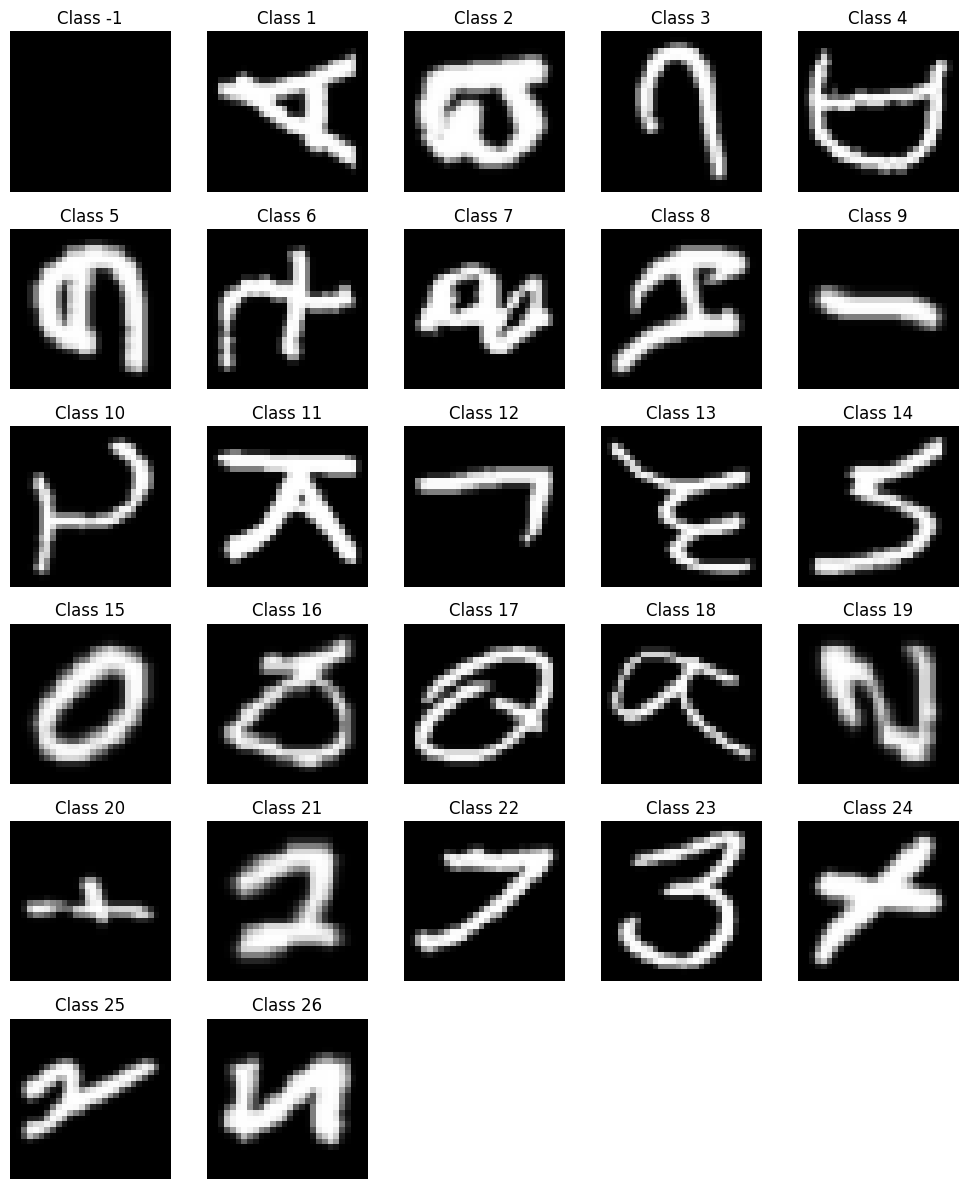

In [9]:
image_size = 28
classes = data[:, 0]

# Reshape pixel data into images
num_images = data[:, 1:].shape[0]
images = data[:, 1:].reshape(num_images, image_size, image_size).astype(np.uint8)

# Get unique classes
unique_classes = np.unique(classes)

def plot_random_images_per_class(images, classes, num_images_per_row=5):
    num_classes = len(unique_classes)
    num_rows = int(np.ceil(num_classes / num_images_per_row))
    
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(num_images_per_row * 2, num_rows * 2))
    
    for i, cls in enumerate(unique_classes):
        class_indices = np.where(classes == cls)[0]
        random_index = np.random.choice(class_indices)
        row = i // num_images_per_row
        col = i % num_images_per_row
        axes[row, col].imshow(images[random_index], cmap='gray')
        axes[row, col].set_title(f'Class {cls}')
        axes[row, col].axis('off')
    
    # Hide any extra subplots if num_classes is not a multiple of num_images_per_row
    for j in range(num_classes, num_rows * num_images_per_row):
        axes.flatten()[j].axis('off')
    
    plt.tight_layout()

# Display one random image from each class in rows of 5
plot_random_images_per_class(images, classes, num_images_per_row=5)
plt.show()

## Number of Images in Each Class

In [10]:
def count_images_per_class(data):
    # Extract classes from the first column
    classes = data.iloc[:, 0]

    # Get unique classes and count occurrences
    unique_classes, counts = np.unique(classes, return_counts=True)

    # Create a dictionary to store class counts
    class_counts = dict(zip(unique_classes, counts))

    return class_counts

In [11]:
def plot_class_distribution(data):
    classes = data.iloc[:, 0]

    # Get unique classes and count occurrences
    unique_classes, counts = np.unique(classes, return_counts=True)

    # Plotting the graph
    plt.figure(figsize=(10, 6))
    plt.bar(unique_classes, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Class')
    plt.xticks(unique_classes)
    plt.show()

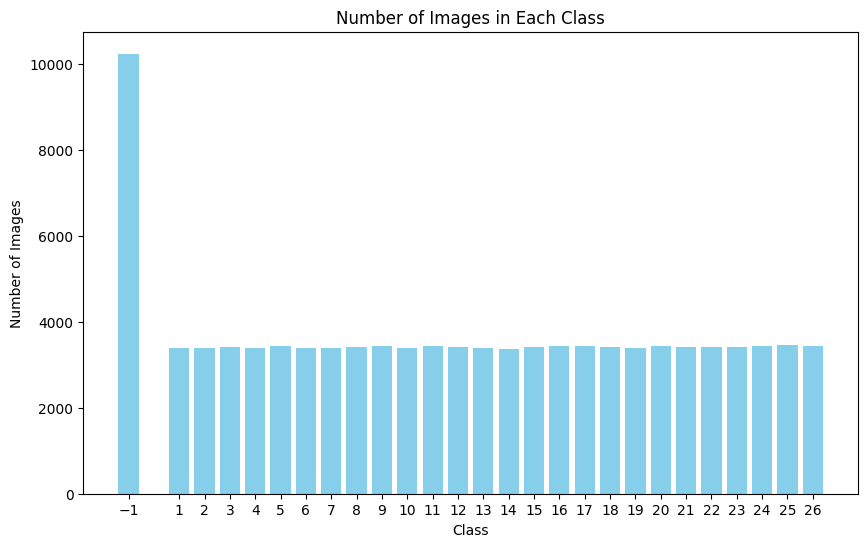

In [12]:
plot_class_distribution(df)

## Further Investigating the '-1' Class

### Display rows with class '-1'

In [13]:
minus_one_class_df = pd.DataFrame(data[data[:, 0] == -1])
minus_one_class_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,-1,89,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,89,89,89
1,-1,216,216,216,216,216,216,216,216,216,...,216,216,216,216,216,216,216,216,216,216
2,-1,74,74,74,74,74,74,74,74,74,...,74,74,74,74,74,74,74,74,74,74
3,-1,148,148,148,148,148,148,148,148,148,...,148,148,148,148,148,148,148,148,148,148
4,-1,103,103,103,103,103,103,103,103,103,...,103,103,103,103,103,103,103,103,103,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,-1,205,205,205,205,205,205,205,205,205,...,205,205,205,205,205,205,205,205,205,205
10236,-1,153,153,153,153,153,153,153,153,153,...,153,153,153,153,153,153,153,153,153,153
10237,-1,132,132,132,132,132,132,132,132,132,...,132,132,132,132,132,132,132,132,132,132
10238,-1,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174


### Rows with pixel values constant

In [14]:
print(f"Number of constant pixel value images: {minus_one_class_df[minus_one_class_df.apply(is_constant_image, axis=1)].shape[0]}")

Number of constant pixel value images: 10240


# Data Cleaning <a id = '3.1'></a>

### Excluding Images with Constant Pixel Values

In [15]:
# Duplicate DF
cleaned_df = df.copy()

# Filtering
cleaned_df = cleaned_df[cleaned_df.iloc[:, 0] != -1]

# Print the number of images after removing blank images
print(f'Number of images after removing blank images: {cleaned_df.shape[0]}')
cleaned_df

Number of images after removing blank images: 88800


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99032,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99033,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99035,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99036,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Unique Classes in the Dataset after cleaning

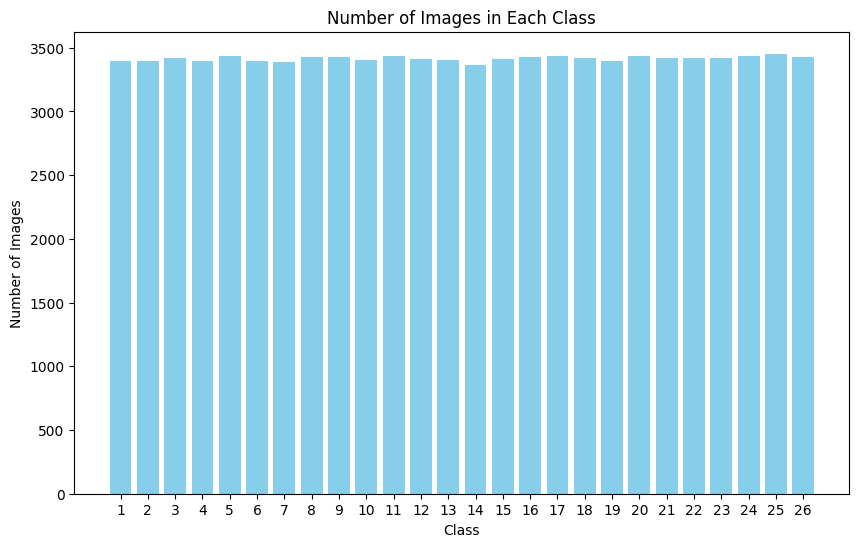

In [16]:
plot_class_distribution(cleaned_df)

# Data Preprocessing <a id = '5'></a>

## Normalizing the images

In [17]:
# Convert DataFrame to NumPy array
data = cleaned_df.values

# Assuming each image is 28x28 pixels and the remaining columns are pixel values
image_size = 28
num_images = data.shape[0]

# Extract labels and pixel data
labels = data[:, 0]
pixel_data = data[:, 1:]

# Extract pixel data and reshape each row into a 28x28 array
original_images = data[:, 1:].reshape(num_images, image_size, image_size).astype(np.uint8)

# Normalize pixel values
normalized_images = original_images / 255.0

# Flatten the normalized images back to rows
flattened_normalized_images = normalized_images.reshape(num_images, -1)

# Combine labels and flattened normalized images
combined_data = np.column_stack((labels, flattened_normalized_images))

# Create a new dataframe with the combined data
normalized_df = pd.DataFrame(combined_data, columns=cleaned_df.columns)

# Display the first few rows of the new dataframe
normalized_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88795,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88796,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88797,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88798,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Augmentation

### Number of Images in each class

In [18]:
count_per_class = count_images_per_class(normalized_df)
count_per_class

{1.0: 3396,
 2.0: 3396,
 3.0: 3419,
 4.0: 3398,
 5.0: 3437,
 6.0: 3394,
 7.0: 3385,
 8.0: 3424,
 9.0: 3428,
 10.0: 3402,
 11.0: 3438,
 12.0: 3415,
 13.0: 3402,
 14.0: 3365,
 15.0: 3408,
 16.0: 3430,
 17.0: 3435,
 18.0: 3419,
 19.0: 3392,
 20.0: 3436,
 21.0: 3419,
 22.0: 3422,
 23.0: 3423,
 24.0: 3437,
 25.0: 3453,
 26.0: 3427}

### Image needed for each class

In [19]:
target_per_class = 3500
no_images_needed_per_class = {}
print('Image needed for each class')
for key, value in count_per_class.items():
    no_images_needed_per_class[key] = target_per_class - value
no_images_needed_per_class

Image needed for each class


{1.0: 104,
 2.0: 104,
 3.0: 81,
 4.0: 102,
 5.0: 63,
 6.0: 106,
 7.0: 115,
 8.0: 76,
 9.0: 72,
 10.0: 98,
 11.0: 62,
 12.0: 85,
 13.0: 98,
 14.0: 135,
 15.0: 92,
 16.0: 70,
 17.0: 65,
 18.0: 81,
 19.0: 108,
 20.0: 64,
 21.0: 81,
 22.0: 78,
 23.0: 77,
 24.0: 63,
 25.0: 47,
 26.0: 73}

### Resample data

In [20]:
resampled_df_data = []
for class_label, target_count in no_images_needed_per_class.items():
    class_data = normalized_df[normalized_df[0] == class_label]
    # Resample the images
    resampled_df_data.append(resample(class_data, n_samples = target_count, random_state=42))



# Reset index for the resampled dataframe
resampled_df = pd.concat(resampled_df_data)
resampled_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
82575,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33586,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29379,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28419,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77509,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39088,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66412,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20396,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Assuming resampled_df is your dataframe with labels and pixel values

# Extract the labels and images
labels = resampled_df.iloc[:, 0].values
images = resampled_df.iloc[:, 1:].values.reshape(-1, 28, 28, 1)

# Define the ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Augment the entire dataset
augmented_images = []
augmented_labels = []

for image, label in zip(images, labels):
    image = image.reshape(1, 28, 28, 1)  # Reshape to (1, 28, 28, 1) for the generator
    aug_iter = datagen.flow(image, batch_size=1)
    aug_image = next(aug_iter)[0].astype(np.float32)  # Normalize the image
    augmented_images.append(aug_image)
    augmented_labels.append(label)

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)


# Flatten images back to the original format and create a new DataFrame
flattened_images = augmented_images.reshape(-1, 28*28)
augmented_df = pd.DataFrame(flattened_images)
augmented_df.insert(0, 'label', augmented_labels)

augmented_df.head()

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.071571,0.455918,0.580693,0.316873,0.047280,0.001626,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.000000,0.000000,0.003341,0.005107,0.001569,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000473,0.003245,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Sample of the augmented dataframe

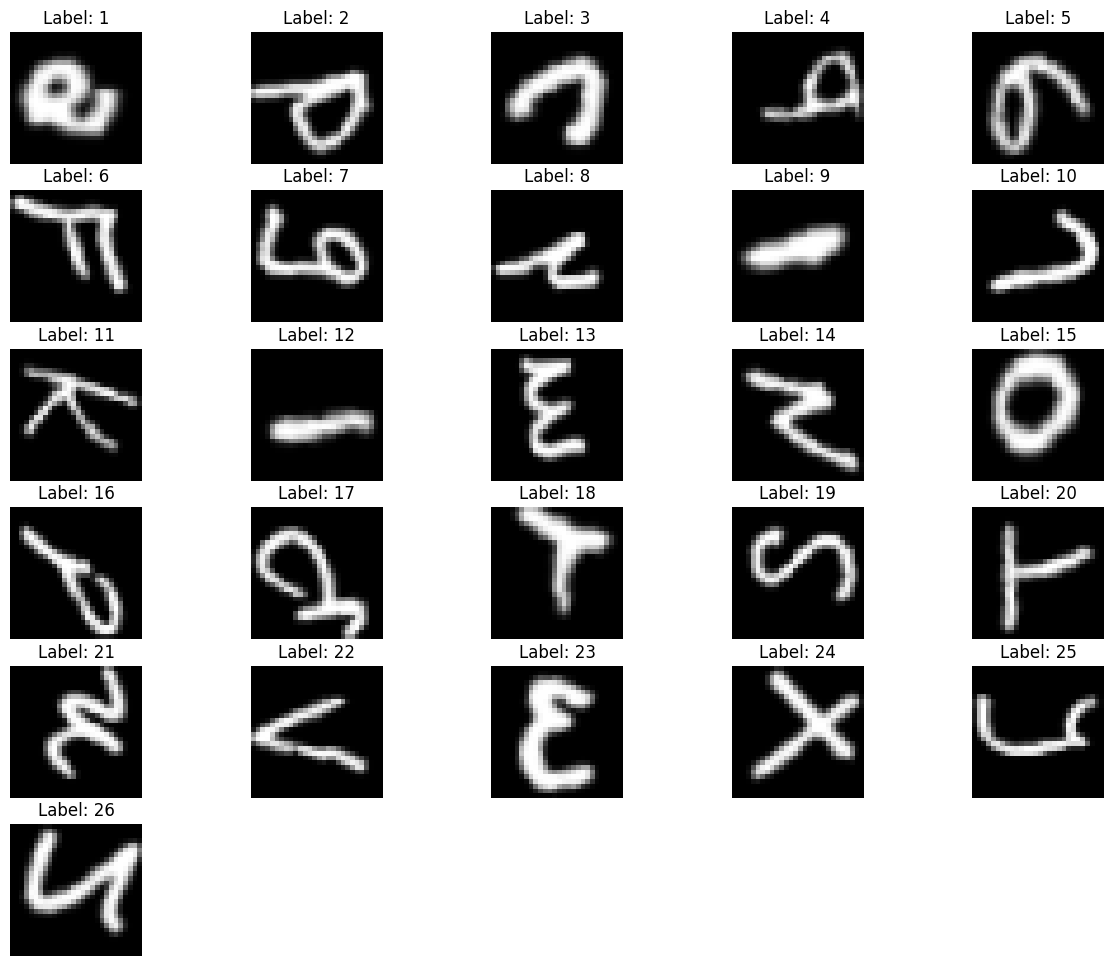

In [22]:
# Display one sample per class from the augmented DataFrame
def display_samples_per_class(augmented_df, num_classes=26, images_per_row=5):
    # Convert the DataFrame to numpy array
    data_array = augmented_df.values
    
    # Separate the labels and pixel values
    labels = data_array[:, 0]
    pixels = data_array[:, 1:]
    
    # Get unique classes and sample one image per class
    unique_classes = np.unique(labels)
    sampled_data = []

    for cls in unique_classes:
        sample = augmented_df[augmented_df.iloc[:, 0] == cls].sample(n=1).values[0]
        sampled_data.append(sample)
    
    sampled_data = np.array(sampled_data)
    
    # Separate the sampled labels and pixel values
    sampled_labels = sampled_data[:, 0]
    sampled_pixels = sampled_data[:, 1:]
    
    # Reshape pixel values to original image dimensions (assuming 28x28 images)
    image_size = (28, 28) 
    num_channels = 1 
    
    # Plot the samples
    plt.figure(figsize=(15, 2*(num_classes // images_per_row + 1)))
    for i in range(len(sampled_labels)):
        image = sampled_pixels[i].reshape(image_size[0], image_size[1], num_channels)
        plt.subplot(num_classes // images_per_row + 1, images_per_row, i+1)
        plt.imshow(image.squeeze(), cmap='gray' if num_channels == 1 else None)
        plt.title(f'Label: {int(sampled_labels[i])}')
        plt.axis('off')
    plt.show()

# Display one sample per class from the augmented DataFrame
display_samples_per_class(augmented_df, num_classes=26, images_per_row=5)

### Add the augmented images back to the dataframe

In [23]:
# Create a dictionary to rename columns from their current names to 0 to 784
column_names = {old_name: new_name for old_name, new_name in zip(augmented_df.columns, range(len(augmented_df.columns)))}

# Rename the columns of augmented_df
augmented_df.rename(columns=column_names, inplace=True)
augmented_df

# Concatenate the dataframes
preprocessed_df = pd.concat([cleaned_df, augmented_df], axis=0, ignore_index=True)

# Display the first few rows of the combined dataframe
preprocessed_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90995,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
90996,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
90997,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
90998,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00002,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


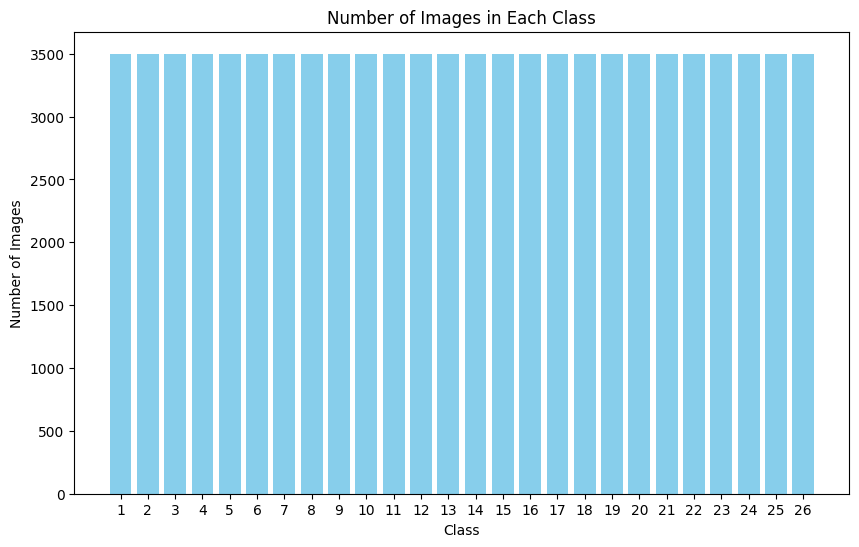

In [24]:
plot_class_distribution(preprocessed_df)

## Original | Normalized | Binarized <a id = '3.1'></a>

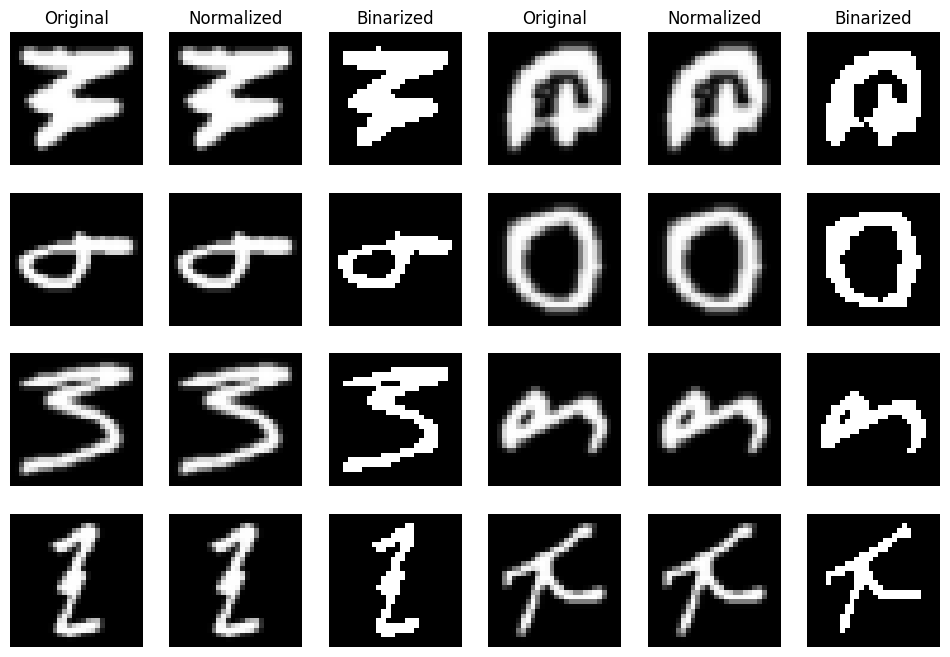

In [25]:
# Convert DataFrame to NumPy array
data = cleaned_df.values

# Assuming each image is 28x28 pixels and the remaining columns are pixel values
image_size = 28
num_images = data.shape[0]

# Extract pixel data and reshape each row into a 28x28 array
original_images = data[:, 1:].reshape(num_images, image_size, image_size).astype(np.uint8)

# Normalize pixel values
normalized_images = original_images / 255.0

# Binarize the images by applying a threshold
threshold = 0.5
binarized_images = (normalized_images > threshold).astype(np.uint8)

# Define a function to display multiple images before and after processing
def plot_images(original_images, normalized_images, binarized_images, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols*3, figsize=(ncols*6, nrows*2))
    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            if index < len(original_images):
                # Display original image
                ax_original = axes[i, j*3]
                ax_original.imshow(original_images[index], cmap='gray')
                ax_original.axis('off')
                if i == 0:
                    ax_original.set_title('Original')
                
                # Display normalized image
                ax_normalized = axes[i, j*3 + 1]
                ax_normalized.imshow(normalized_images[index], cmap='gray')
                ax_normalized.axis('off')
                if i == 0:
                    ax_normalized.set_title('Normalized')
                
                # Display binarized image
                ax_binarized = axes[i, j*3 + 2]
                ax_binarized.imshow(binarized_images[index], cmap='gray')
                ax_binarized.axis('off')
                if i == 0:
                    ax_binarized.set_title('Binarized')

# Display the first 10 images before and after processing
num_display = 8
plot_images(original_images[:num_display], normalized_images[:num_display], binarized_images[:num_display], nrows=4, ncols=2)
plt.show()

## Enhancing Image using processing techniques <a id = '3.1'></a>

In [26]:
import cv2
from skimage import exposure

def preprocess_image(img):

    # Convert image to uint8 format# Convert image to uint8 format
    img = img.astype(np.uint8)
    
    # Gaussian smoothing for noise reduction
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Unsharp masking to enhance details
    # img = cv2.addWeighted(img, 1.5, imgG, -0.4, 0)

    # Contrast adjustment
    img = cv2.convertScaleAbs(img, alpha=1.5, beta=0)
    
    # Histogram equalization
    img = exposure.equalize_hist(img)
    
    # Sharpening Filters
    # img = cv2.Laplacian(img, cv2.CV_64F)
    
    return img

preprocessed_images = np.array([preprocess_image(img) for img in binarized_images])

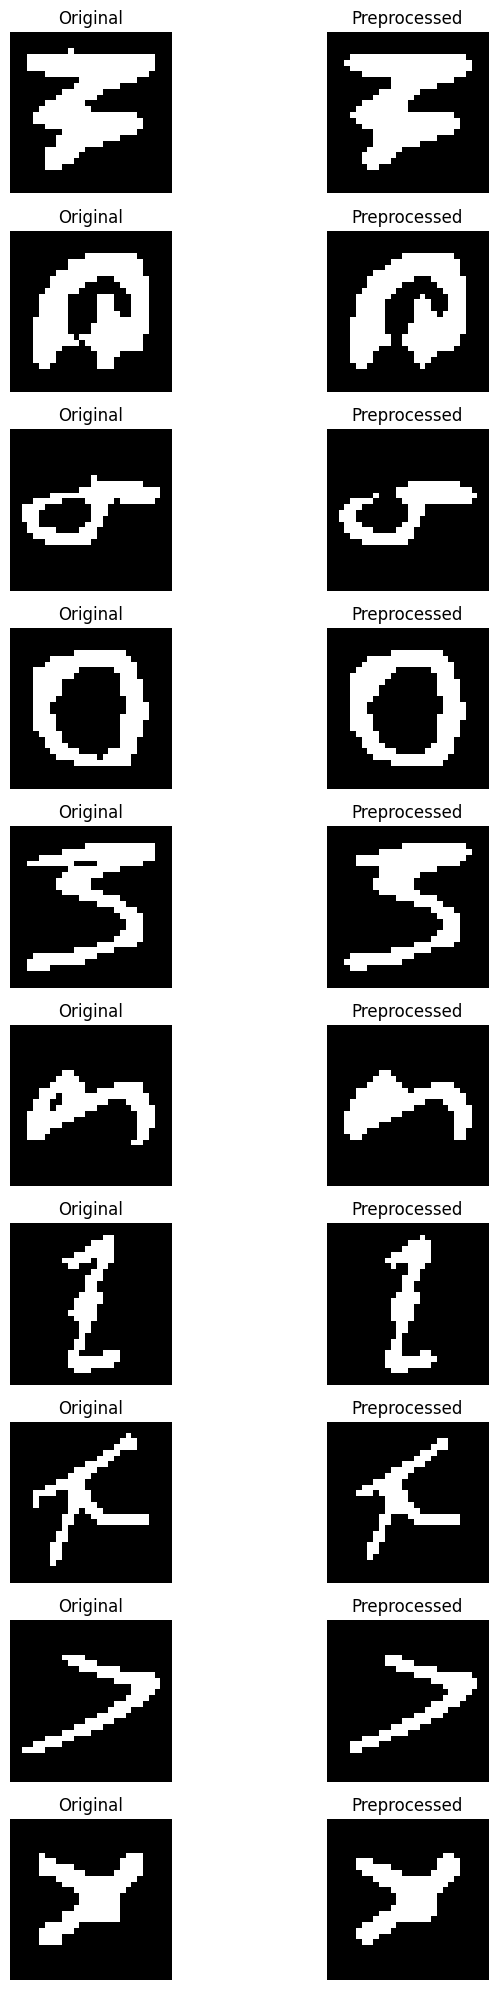

In [27]:
# Display the first 10 images before and after preprocessing
fig, axes = plt.subplots(10, 2, figsize=(8, 20))

for i in range(10):
    # Before preprocessing
    img_before = binarized_images[i]  # Directly use the 28x28 image
    axes[i, 0].imshow(img_before, cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    # After preprocessing
    img_after = preprocessed_images[i]
    axes[i, 1].imshow(img_after, cmap='gray')
    axes[i, 1].set_title('Preprocessed')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Evaluation metrics for GANs

Explanation
- Unlike other deep learning neural network models that are trained with a loss function until convergence, a GAN generator model is trained using a second model called a discriminator that learns to classify images as real or generated. As such, there is no objective loss function used to train the GAN generator models and no way to objectively assess the progress of the training and the relative or absolute quality of the model from loss alone.
- Instead, a suite of qualitative and quantitative techniques have been developed to assess the performance of a GAN model based on the quality and diversity of the generated synthetic images.

Manual GAN Generator Evaluation
- This involves using the generator model to create a batch of synthetic images, then evaluating the quality and diversity of the images in relation to the target domain. This may be performed by the researcher or practitioner themselves.
- Although manual inspection is the simplest method of model evaluation, it has many limitations, such as the fact that it is subjective, including biases of the reviewer about the model, its configuration, and the project objective. It requires knowledge of what is realistic and what is not for the target domain and is limited to the number of images that can be reviewed in a reasonable time.

Qualitative GAN Generator Evaluation
- Qualitative measures are those measures that are not numerical and often involve human subjective evaluation or evaluation via comparison. Five qualitative techniques for evaluating GAN generator models are listed below.
- Nearest Neighbors.
- Rapid Scene Categorization.
- Rating and Preference Judgment.
- Evaluating Mode Drop and Mode Collapse.
- Investigating and Visualizing the Internals of Networks.

Quantitative GAN Generator Evaluation
- Quantitative GAN generator evaluation refers to the calculation of specific numerical scores used to summarize the quality of generated images. Twenty-four quantitative techniques for evaluating GAN generator models are listed below.
- Average Log-likelihood
- Coverage Metric
- Inception Score (IS)
- Modified Inception Score (m-IS)
- Mode Score
- AM Score
- Frechet Inception Distance (FID)
- Maximum Mean Discrepancy (MMD)
- The Wasserstein Critic
- Birthday Paradox Test
- Classifier Two-sample Tests (C2ST)
- Classification Performance
- Boundary Distortion
- Number of Statistically-Different Bins (NDB)
- Image Retrieval Performance
- Generative Adversarial Metric (GAM)
- Tournament Win Rate and Skill Rating
- Normalized Relative Discriminative Score (NRDS)
- Adversarial Accuracy and Adversarial Divergence
- Geometry Score
- Reconstruction Error
- Image Quality Measures (SSIM, PSNR and Sharpness Difference)
- Low-level Image Statistics
- Precision, Recall and F1 Score

Reference: https://machinelearningmastery.com/how-to-evaluate-generative-adversarial-networks/

## Inception Score (IS)

In [40]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from scipy.stats import entropy

def calculate_inception_score(images, n_split=10):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    images = np.repeat(images, 3, axis=-1)  # Repeat grayscale to RGB channels
    images = preprocess_input(images)
    images = np.array([np.resize(img, (299, 299, 3)) for img in images])
    preds = model.predict(images)
    scores = []
    for i in range(n_split):
        part = preds[i * len(images) // n_split: (i + 1) * len(images) // n_split]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)


## Frechet Inception Distance (FID)

In [59]:
from keras.applications import InceptionV3
from scipy.linalg import sqrtm
import numpy as np
import tensorflow as tf

def calculate_fid(X_train, gen_imgs):
    # Preprocess images for InceptionV3
    X_train = (X_train * 255).astype(np.uint8)
    gen_imgs = (gen_imgs * 255).astype(np.uint8)
    
    # Resize images for InceptionV3 (75x75)
    X_train_resized = tf.image.resize(X_train, (75, 75))
    gen_imgs_resized = tf.image.resize(gen_imgs, (75, 75))
    
    # Scale images to range [-1, 1] for InceptionV3
    X_train_rescaled = (X_train_resized - 127.5) / 127.5
    gen_imgs_rescaled = (gen_imgs_resized - 127.5) / 127.5
    
    # Load InceptionV3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))
    
    # Get feature representations of generated and real images
    act_gen = model.predict(gen_imgs_rescaled)
    act_real = model.predict(X_train_rescaled)
    
    # Calculate mean and covariance statistics
    mu_gen, sigma_gen = np.mean(act_gen, axis=0), np.cov(act_gen, rowvar=False)
    mu_real, sigma_real = np.mean(act_real, axis=0), np.cov(act_real, rowvar=False)
    
    # Calculate FID score
    ssdiff = np.sum((mu_gen - mu_real)**2.0)
    covmean = sqrtm(sigma_gen.dot(sigma_real))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma_gen + sigma_real - 2.0 * covmean)
    
    return fid



def plot_metrics(d_losses, g_losses, fid_scores):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(d_losses, label='Discriminator Loss', alpha=0.8)
    plt.plot(g_losses, label='Generator Loss', alpha=0.8)
    plt.title("Training Losses")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(fid_scores, label='FID Score', alpha=0.8)
    plt.title("FID Score")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Deep Convolutional GANs

## Base Model

In [80]:
class DCGAN():
    
    # this is the function to build the generator neural network
    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim)) # connect the input to dense layer
        model.add(Reshape((7, 7, 128)))
        # upsample from 7*7 to 14*14
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)  # the keras Model class groups layers into an object with training and inference features
    
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stablize training and reduce oscillation
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
            optimizer=optimizer)
    
    def train(self, epochs, batch_size=128, save_interval=50):
        # Assuming your data is in a pandas DataFrame `df`
        # Extract image data and convert to numpy array
        X_train = preprocessed_df.iloc[:, 1:].values  # assuming first column is labels, rest are pixels
        X_train = X_train.astype(np.float32) / 255.0  # normalize pixel values to [0, 1]
        X_train = X_train.reshape(-1, self.img_rows, self.img_cols, self.channels)  # reshape to image shape
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            # Train the discriminator (classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            # Train Generator
            # ---------------------
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            # Train the generator (generator wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)
            
            # Print progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        fig.savefig("generated_mnist/DCGAN/dcgan_mnist_{:d}.png".format(epoch))
        plt.close()

In [81]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=5000, batch_size=256, save_interval=50)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_433 (Conv2D)         (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_76 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 dropout_38 (Dropout)        (None, 14, 14, 128)       0         
                                                                 
 conv2d_434 (Conv2D)         (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_77 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_39 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_53 (Flatten)        (None, 6272)            

KeyboardInterrupt: 

At 100 epochs:

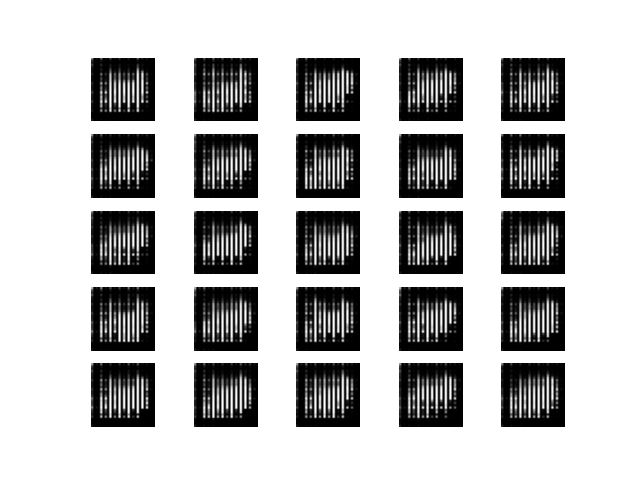

At 4950 epochs:

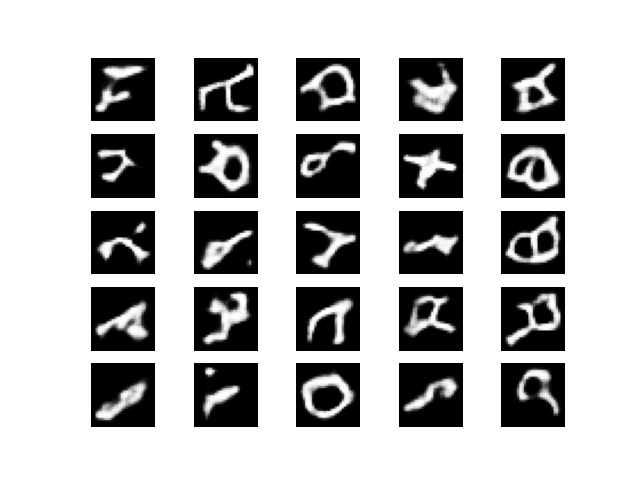

## Use stridded convolutions

__References__

https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import os

class DCGAN():
    
    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim)) # connect the input to dense layer
        model.add(Reshape((7, 7, 128)))
        # upsample from 7*7 to 14*14
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def __init__(self, rows, cols, channels, z=100):
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z

        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False
        valid = self.discriminator(img)

        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def train(self, epochs, batch_size=128, save_interval=50):
        # Assuming your data is in a pandas DataFrame `df`
        # Extract image data and convert to numpy array
        X_train = preprocessed_df.iloc[:, 1:].values  # assuming first column is labels, rest are pixels
        X_train = X_train.astype(np.float32) / 255.0  # normalize pixel values to [0, 1]
        X_train = X_train.reshape(-1, self.img_rows, self.img_cols, self.channels)  # reshape to image shape
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            # Train the discriminator (classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            # Train Generator
            # ---------------------
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            # Train the generator (generator wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)
            
            # Print progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        fig.savefig("generated_mnist/DCGAN/dcgan_mnist_stridded_{:d}.png".format(epoch))
        plt.close()

# Example usage:
rows = 28
cols = 28
channels = 1
dcgan = DCGAN(rows, cols, channels)
dcgan.train(epochs=5000, batch_size=256, save_interval=50)  # Adjust preprocessed_df with your actual data


At 100 epochs:

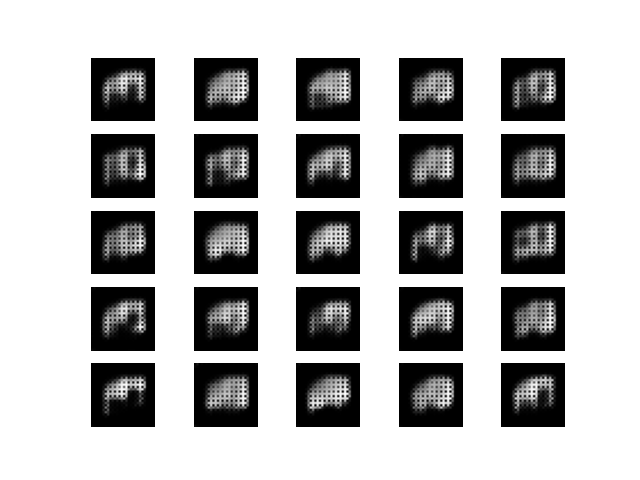

At 4950 epochs

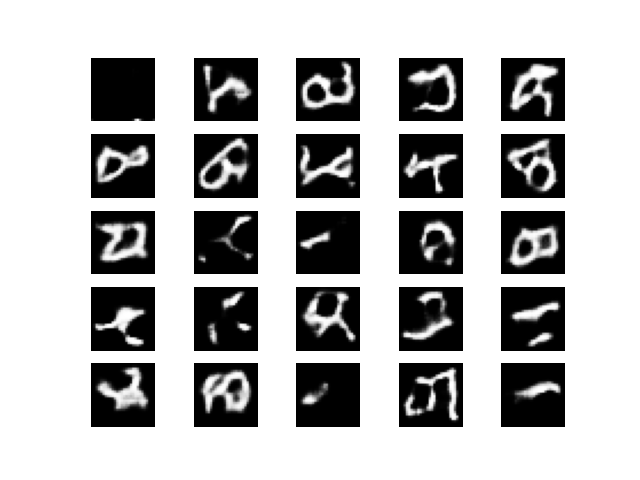

# Conditional GANs <a id = '3.1'></a>

Explantion
- CGANs is a type of Generative Adversarial Network that adds additional information into both the generator and the discriminator to condition the generation process. This additional information can be any type of label or structured data such as class labels, images or other data that helps the generation process.
- It allows the generator to create more controlled and contextually appropriate outputs by using the additional information given to it.

Difference between CGANs and DCGANs
- CGANs uses additional information as conditions into the generation process while DCGANs focus on using convolutional networks for better performance in image data.
- CGANs are used for tasks that need controlled generated based on the input conditions while DCGANs are used for generating high-quality, realistic images.
- CGANs defining feature is the conditioning mechanism while DCGANs specifically use deep convolutional networks for both the generator and discriminator, emphasizing the architecture rather than conditioning.
- When training, CGANs need X, y labels as it is designed to generate images conditioned on a specific label while DCGANs only need X labels as it is designed to generate images without any conditional information.

Reference: https://medium.com/analytics-vidhya/dcgan-cgan-and-sagan-the-cifar-10-dataset-206cbb851327

In [117]:
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Dropout, Input, Embedding, multiply, Concatenate
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os

class CGAN():
    
    def __init__(self, rows, cols, channels, num_classes, latent_dim=100):
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels  # Updated to handle grayscale (1 channel)
        self.num_classes = num_classes
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = latent_dim
        
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        # Build the generator
        self.generator = self.build_generator()
        
        # The generator takes noise and the label as input and generates images
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])
        
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator([img, label])
        
        # The combined model (stacked generator and discriminator)
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        # Loss function
        self.d_losses = []
        self.g_losses = []

        # Initialize variables for tracking best MSE
        self.best_mse = float('inf')  # Initialize with a very large number
        self.best_generated_imgs = None
        
    def build_generator(self):
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        model_input = Concatenate()([noise, label_embedding])
        
        model = Sequential(name='Generator')
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim + self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))  # Output single-channel (grayscale)
        model.summary()
        
        img = model(model_input)
        return Model([noise, label], img)
    
    def build_discriminator(self):
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')
        
        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        label_embedding = Reshape(self.img_shape)(label_embedding)
        
        model_input = multiply([img, label_embedding])
        
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        validity = model(model_input)
        return Model([img, label], validity)

    def compute_mse(self, real_images, generated_images):
        # Sample the same number of images from generated_images as from real_images
        num_images = real_images.shape[0]
        gen_images_sampled = generated_images[np.random.randint(0, generated_images.shape[0], num_images)]
        
        # Compute MSE
        mse = np.mean((real_images - gen_images_sampled) ** 2)
        return mse

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.d_losses)), self.d_losses, label="Discriminator loss")
        plt.plot(range(len(self.g_losses)), self.g_losses, label="Generator loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def train(self, epochs, batch_size=128, save_interval=50):

        # Extract image data and convert to numpy array
        X_train = preprocessed_df.iloc[:, 1:].values
        y_train = preprocessed_df.iloc[:, 0].values
        X_train = X_train.astype(np.float32) / 255.0
        X_train = X_train.reshape(-1, self.img_rows, self.img_cols, self.channels)
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]
            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_labels = np.random.randint(0, self.num_classes, batch_size)
            gen_imgs = self.generator.predict([noise, gen_labels])
            
            # Train the discriminator (classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, gen_labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            # Train Generator
            # ---------------------
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            valid_labels = np.random.randint(0, self.num_classes, batch_size)
            
            # Train the generator (generator wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch([noise, valid_labels], valid)
    
            # Store losses
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            
            # Print progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                
                # Calculate MSE score
                real_images = X_train[np.random.randint(0, X_train.shape[0], 100)]
                mse_score = self.compute_mse(real_images, gen_imgs)
                print(f"MSE score at epoch {epoch}: {mse_score}")
                
                # Update best MSE and save corresponding generated images
                if mse_score < self.best_mse:
                    self.best_mse = mse_score
                    self.best_generated_imgs = gen_imgs.copy()
            
        # Plot losses for every epoch
        self.plot_loss()
            
        # Print best MSE score found during training
        print(f"Best MSE score: {self.best_mse}")
    
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.random.randint(0, self.num_classes, r * c).reshape(-1, 1)
    
        gen_imgs = self.generator.predict([noise, sampled_labels])
    
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')  # Display grayscale images
                axs[i, j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        fig.savefig("generated_mnist/CGAN/cgan_mnist_{:d}.png".format(epoch))
        plt.close()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_760 (Conv2D)         (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_136 (LeakyReLU)  (None, 14, 14, 128)      0         
                                                                 
 dropout_68 (Dropout)        (None, 14, 14, 128)       0         
                                                                 
 conv2d_761 (Conv2D)         (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_137 (LeakyReLU)  (None, 7, 7, 128)        0         
                                                                 
 dropout_69 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_97 (Flatten)        (None, 6272)            

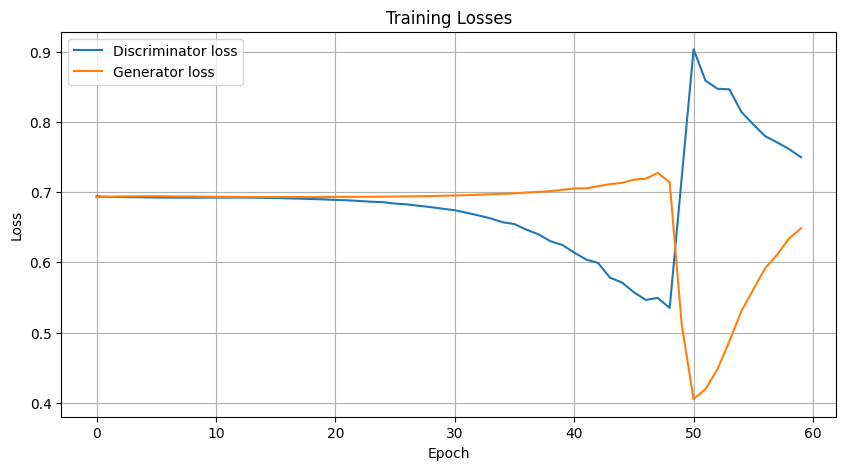

Best MSE score: 0.18668057024478912


In [118]:
# Example usage:
# Assuming `preprocessed_df` is the preprocessed DataFrame with labels in the first column
num_classes = preprocessed_df.iloc[:, 0].nunique()
cgan = CGAN(rows=28, cols=28, channels=1, num_classes=num_classes)
cgan.train(epochs=60, batch_size=256, save_interval=50)

# Try

In [ ]:
# from keras.models import Sequential, Model
# from keras.layers import Dense, Reshape, Flatten, Dropout, Input, Embedding, multiply, Concatenate
# from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
# from keras.optimizers import Adam
# import numpy as np
# import matplotlib.pyplot as plt
# import os

# class CGAN():
    
#     def __init__(self, rows, cols, channels, num_classes, latent_dim=100):
#         self.img_rows = rows
#         self.img_cols = cols
#         self.channels = channels
#         self.num_classes = num_classes
#         self.img_shape = (self.img_rows, self.img_cols, self.channels)
#         self.latent_dim = latent_dim
        
#         optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        
#         # Build and compile the discriminator
#         self.discriminator = self.build_discriminator()
#         self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
#         # Build the generator
#         self.generator = self.build_generator()
        
#         # The generator takes noise and the label as input and generates images
#         noise = Input(shape=(self.latent_dim,))
#         label = Input(shape=(1,))
#         img = self.generator([noise, label])
        
#         # For the combined model we will only train the generator
#         self.discriminator.trainable = False
        
#         # The discriminator takes generated images as input and determines validity
#         valid = self.discriminator([img, label])
        
#         # The combined model (stacked generator and discriminator)
#         self.combined = Model([noise, label], valid)
#         self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
#     def build_generator(self):
#         noise = Input(shape=(self.latent_dim,))
#         label = Input(shape=(1,), dtype='int32')
        
#         label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
#         model_input = Concatenate()([noise, label_embedding])
        
#         model = Sequential(name='Generator')
#         model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim + self.latent_dim))
#         model.add(Reshape((7, 7, 128)))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))
#         model.summary()
        
#         img = model(model_input)
#         return Model([noise, label], img)
    
#     def build_discriminator(self):
#         img = Input(shape=self.img_shape)
#         label = Input(shape=(1,), dtype='int32')
        
#         label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
#         label_embedding = Reshape(self.img_shape)(label_embedding)
        
#         model_input = multiply([img, label_embedding])
        
#         model = Sequential(name='Discriminator')
#         model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.4))
#         model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.4))
#         model.add(Flatten())
#         model.add(Dense(1, activation='sigmoid'))
#         model.summary()
        
#         validity = model(model_input)
#         return Model([img, label], validity)
    
#     def train(self, epochs, batch_size=128, save_interval=50):
#         # Assuming your data is in a pandas DataFrame preprocessed_df
#         # Extract image data and convert to numpy array
#         X_train = preprocessed_df.iloc[:, 1:].values
#         y_train = preprocessed_df.iloc[:, 0].values
#         X_train = X_train.astype(np.float32) / 255.0
#         X_train = X_train.reshape(-1, self.img_rows, self.img_cols, self.channels)
        
#         # Adversarial ground truths
#         valid = np.ones((batch_size, 1))
#         fake = np.zeros((batch_size, 1))
        
#         for epoch in range(epochs):
#             # ---------------------
#             # Train Discriminator
#             # ---------------------
#             # Select a random half of images
#             idx = np.random.randint(0, X_train.shape[0], batch_size)
#             imgs, labels = X_train[idx], y_train[idx]
            
#             # Sample noise and generate a batch of new images
#             noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
#             gen_labels = np.random.randint(0, self.num_classes, batch_size)
#             gen_imgs = self.generator.predict([noise, gen_labels])
            
#             # Train the discriminator (classify real images as 1 and generated images as 0)
#             d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
#             d_loss_fake = self.discriminator.train_on_batch([gen_imgs, gen_labels], fake)
#             d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
#             # ---------------------
#             # Train Generator
#             # ---------------------
#             # Sample noise and generate a batch of new images
#             noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
#             valid_labels = np.random.randint(0, self.num_classes, batch_size)
            
#             # Train the generator (generator wants discriminator to predict generated images as 1)
#             g_loss = self.combined.train_on_batch([noise, valid_labels], valid)
            
#             # Print progress
#             print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            
#             # If at save interval => save generated image samples
#             if epoch % save_interval == 0:
#                 self.save_imgs(epoch)
    
#     def save_imgs(self, epoch):
#         r, c = 5, 5
#         noise = np.random.normal(0, 1, (r * c, self.latent_dim))
#         sampled_labels = np.random.randint(0, self.num_classes, r * c).reshape(-1, 1)
    
#         gen_imgs = self.generator.predict([noise, sampled_labels])
    
#         fig, axs = plt.subplots(r, c)
#         cnt = 0
#         for i in range(r):
#             for j in range(c):
#                 axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
#                 axs[i, j].axis('off')
#                 cnt += 1
#         os.makedirs('generated_mnist', exist_ok=True)
#         fig.savefig("generated_mnist/CGAN/cgan_mnist_{:d}.png".format(epoch))
#         plt.close()

In [ ]:
# from keras.models import Sequential, Model
# from keras.layers import Dense, Reshape, Flatten, Dropout, Input, Embedding, multiply, Concatenate
# from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
# from keras.optimizers import Adam
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from keras.applications import InceptionV3
# from scipy.linalg import sqrtm
# import tensorflow as tf

# # Define functions for building generator and discriminator
# def build_generator(latent_dim, num_classes, img_shape):
#     noise = Input(shape=(latent_dim,))
#     label = Input(shape=(1,), dtype='int32')
    
#     label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))
#     model_input = Concatenate()([noise, label_embedding])
    
#     model = Sequential(name='Generator')
#     model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim + latent_dim))
#     model.add(Reshape((7, 7, 128)))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Conv2D(img_shape[2], kernel_size=7, padding="same", activation='sigmoid'))
#     model.summary()
    
#     img = model(model_input)
#     return Model([noise, label], img)

# def build_discriminator(img_shape, num_classes):
#     img = Input(shape=img_shape)
#     label = Input(shape=(1,), dtype='int32')
    
#     label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
#     label_embedding = Reshape(img_shape)(label_embedding)
    
#     model_input = multiply([img, label_embedding])
    
#     model = Sequential(name='Discriminator')
#     model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.4))
#     model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.4))
#     model.add(Flatten())
#     model.add(Dense(1, activation='sigmoid'))
#     model.summary()
    
#     validity = model(model_input)
#     return Model([img, label], validity)

# def train_gan(X_train, y_train, img_rows, img_cols, channels, num_classes, latent_dim=100, epochs=5000, batch_size=128, save_interval=50):
#     img_shape = (img_rows, img_cols, channels)
#     optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    
#     # Build and compile the discriminator
#     discriminator = build_discriminator(img_shape, num_classes)
#     discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
#     # Build the generator
#     generator = build_generator(latent_dim, num_classes, img_shape)
    
#     # The generator takes noise and the label as input and generates images
#     noise = Input(shape=(latent_dim,))
#     label = Input(shape=(1,))
#     img = generator([noise, label])
    
#     # For the combined model we will only train the generator
#     discriminator.trainable = False
    
#     # The discriminator takes generated images as input and determines validity
#     valid = discriminator([img, label])
    
#     # The combined model (stacked generator and discriminator)
#     combined = Model([noise, label], valid)
#     combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
#     # Initialize lists for storing evaluation metrics
#     d_losses = []
#     g_losses = []
#     fid_scores = []
    
#     # Adversarial ground truths
#     valid = np.ones((batch_size, 1))
#     fake = np.zeros((batch_size, 1))
    
#     for epoch in range(epochs):
#         # ---------------------
#         # Train Discriminator
#         # ---------------------
#         # Select a random half of images
#         idx = np.random.randint(0, X_train.shape[0], batch_size)
#         imgs, labels = X_train[idx], y_train[idx]
        
#         # Sample noise and generate a batch of new images
#         noise = np.random.normal(0, 1, (batch_size, latent_dim))
#         gen_labels = np.random.randint(0, num_classes, batch_size)
#         gen_imgs = generator.predict([noise, gen_labels])
        
#         # Train the discriminator (classify real images as 1 and generated images as 0)
#         d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
#         d_loss_fake = discriminator.train_on_batch([gen_imgs, gen_labels], fake)
#         d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
#         # ---------------------
#         # Train Generator
#         # ---------------------
#         # Sample noise and generate a batch of new images
#         noise = np.random.normal(0, 1, (batch_size, latent_dim))
#         valid_labels = np.random.randint(0, num_classes, batch_size)
        
#         # Train the generator (generator wants discriminator to predict generated images as 1)
#         g_loss = combined.train_on_batch([noise, valid_labels], valid)
        
#         # Save the losses for plotting
#         d_losses.append(d_loss[0])
#         g_losses.append(g_loss)
        
#         # Calculate FID score every save_interval epochs
#         if epoch % save_interval == 0:
#             fid = calculate_fid(X_train, gen_imgs)
#             fid_scores.append(fid)
#             print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss}] [FID: {fid}]")
#             save_imgs(generator, epoch, latent_dim, num_classes)
    
#     # Plot the losses and FID scores
#     plot_metrics(d_losses, g_losses, fid_scores)

# def save_imgs(generator, epoch, latent_dim, num_classes):
#     r, c = 5, 5
#     noise = np.random.normal(0, 1, (r * c, latent_dim))
#     sampled_labels = np.random.randint(0, num_classes, r * c).reshape(-1, 1)
    
#     gen_imgs = generator.predict([noise, sampled_labels])
    
#     fig, axs = plt.subplots(r, c)
#     cnt = 0
#     for i in range(r):
#         for j in range(c):
#             axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
#             axs[i, j].axis('off')
#             cnt += 1
#     os.makedirs('generated_mnist', exist_ok=True)
#     fig.savefig("generated_mnist/cgan_mnist_{:d}.png".format(epoch))
#     plt.close()

At 100 epochs:

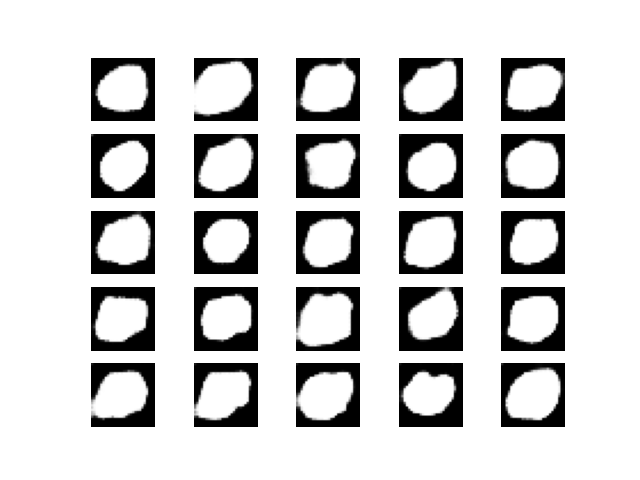

At 4950 epochs:

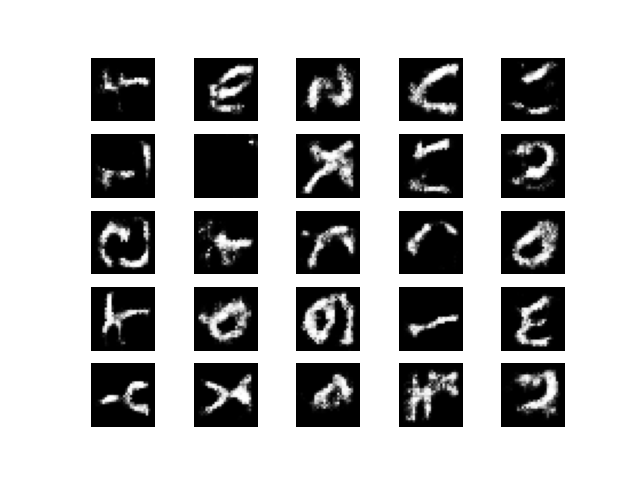

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, Input, Embedding, multiply, Concatenate
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy import linalg

class CGAN():
    
    def __init__(self, rows, cols, channels, num_classes, latent_dim=100):
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels  # Updated to handle grayscale (1 channel)
        self.num_classes = num_classes
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = latent_dim
        
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        # Build the generator
        self.generator = self.build_generator()
        
        # The generator takes noise and the label as input and generates images
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])
        
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator([img, label])
        
        # The combined model (stacked generator and discriminator)
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        # Loss function
        self.d_losses = []
        self.g_losses = []

        # Initialize variables for tracking best MSE
        self.best_mse = float('inf')  # Initialize with a very large number
        self.best_generated_imgs = None
        
    def build_generator(self):
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        model_input = Concatenate()([noise, label_embedding])
        
        model = Sequential(name='Generator')
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim + self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))  # Output single-channel (grayscale)
        model.summary()
        
        img = model(model_input)
        return Model([noise, label], img)
    
    def build_discriminator(self):
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')
        
        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        label_embedding = Reshape(self.img_shape)(label_embedding)
        
        model_input = multiply([img, label_embedding])
        
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        validity = model(model_input)
        return Model([img, label], validity)

    def compute_mse(self, real_images, generated_images):
        # Sample the same number of images from generated_images as from real_images
        num_images = real_images.shape[0]
        gen_images_sampled = generated_images[np.random.randint(0, generated_images.shape[0], num_images)]
        
        # Compute MSE
        mse = np.mean((real_images - gen_images_sampled) ** 2)
        return mse

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.d_losses)), self.d_losses, label="Discriminator loss")
        plt.plot(range(len(self.g_losses)), self.g_losses, label="Generator loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def train(self, epochs, batch_size=128, save_interval=50, csv_file='emnist-letters-train.csv'):

        # Load image data from CSV file
        df = pd.read_csv(csv_file)
        labels = df.iloc[:, 0].values
        images = df.iloc[:, 1:].values.reshape(-1, self.img_rows, self.img_cols, self.channels)
        
        # Normalize images
        images = images.astype(np.float32) / 255.0
        
        # Encode labels if needed
        label_encoder = LabelEncoder()
        labels_encoded = label_encoder.fit_transform(labels)
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, images.shape[0], batch_size)
            imgs, labels = images[idx], labels_encoded[idx]
            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_labels = np.random.randint(0, self.num_classes, batch_size)
            gen_imgs = self.generator.predict([noise, gen_labels])
            
            # Train the discriminator (classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, gen_labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            # Train Generator
            # ---------------------
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            valid_labels = np.random.randint(0, self.num_classes, batch_size)
            
            # Train the generator (generator wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch([noise, valid_labels], valid)
    
            # Store losses
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            
            # Print progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                
                # Calculate MSE score
                real_images = images[np.random.randint(0, images.shape[0], 100)]
                mse_score = self.compute_mse(real_images, gen_imgs)
                print(f"MSE score at epoch {epoch}: {mse_score}")
                
                # Update best MSE and save corresponding generated images
                if mse_score < self.best_mse:
                    self.best_mse = mse_score
                    self.best_generated_imgs = gen_imgs.copy()
            
        # Plot losses for every epoch
        self.plot_loss()
            
        # Print best MSE and save best generated images
        print(f"Best MSE: {self.best_mse}")
        self.save_best_imgs()

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.arange(0, self.num_classes).reshape(-1, 1)
        gen_imgs = self.generator.predict([noise, sampled_labels])
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()

    def save_best_imgs(self):
        if self.best_generated_imgs is not None:
            r, c = 5, 5
            gen_imgs = self.best_generated_imgs[:r * c]
            gen_imgs = 0.5 * gen_imgs + 0.5
            
            fig, axs = plt.subplots(r, c)
            cnt = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                    axs[i,j].axis('off')
                    cnt += 1
            fig.savefig("images/best_mnist_generated.png")
            plt.close()

    def calculate_fid(self, images1, images2):
        # Resize images to 299x299 RGB format
        images1_resized = self.resize_images(images1)
        images2_resized = self.resize_images(images2)
        
        # Preprocess images for Inception-v3
        images1_preprocessed = preprocess_input(images1_resized)
        images2_preprocessed = preprocess_input(images2_resized)
        
        # Load Inception-v3 model without top (classifier) layers
        inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
        
        # Compute activations
        activations1 = inception_model.predict(images1_preprocessed)
        activations2 = inception_model.predict(images2_preprocessed)
        
        # Calculate mean and covariance statistics
        mu1, sigma1 = activations1.mean(axis=0), np.cov(activations1, rowvar=False)
        mu2, sigma2 = activations2.mean(axis=0), np.cov(activations2, rowvar=False)
        
        # Calculate Frechet Distance
        fid_score = linalg.sqrtm(sigma1 @ sigma2.T)
        fid_score = np.real(fid_score).sum() + np.trace(sigma1 + sigma2 - 2 * linalg.sqrtm(sigma1 @ sigma2.T))
        
        return fid_score
    
    def resize_images(self, images):
        from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
        
        resized_images = []
        for img in images:
            img_resized = array_to_img(img).resize((299, 299))
            resized_images.append(img_to_array(img_resized))
        
        return np.array(resized_images)
    
    def calculate_is(self, generated_images):
        # Preprocess images for Inception-v3
        images_preprocessed = preprocess_input(generated_images)
        
        # Load Inception-v3 model without top (classifier) layers
        inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
        
        # Calculate Inception Score
        logits = inception_model.predict(images_preprocessed)
        preds = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
        kl_divs = preds * (np.log(preds) - np.log(np.expand_dims(np.mean(preds, axis=0), 0)))
        is_score = np.exp(np.mean(np.sum(kl_divs, axis=1)))
        
        return is_score


In [143]:
# Example usage:
cgan = CGAN(rows=28, cols=28, channels=1, num_classes=26, latent_dim=100)

# Assuming you have real_images and generated_images defined
real_images = load_real_images(csv_file='emnist-letters-train.csv', img_rows=28, img_cols=28, channels=1)
noise = np.random.normal(0, 1, (100, cgan.latent_dim))
sampled_labels = np.random.randint(0, cgan.num_classes, 100).reshape(-1, 1)
generated_images = cgan.generator.predict([noise, sampled_labels])

# Preprocess images and calculate FID and IS scores
fid_score = cgan.calculate_fid(real_images, generated_images)
is_score = cgan.calculate_is(generated_images)

print(f"FID Score: {fid_score}")
print(f"Inception Score: {is_score}")

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_887 (Conv2D)         (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_180 (LeakyReLU)  (None, 14, 14, 128)      0         
                                                                 
 dropout_90 (Dropout)        (None, 14, 14, 128)       0         
                                                                 
 conv2d_888 (Conv2D)         (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_181 (LeakyReLU)  (None, 7, 7, 128)        0         
                                                                 
 dropout_91 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_130 (Flatten)       (None, 6272)            

MemoryError: Unable to allocate 296. MiB for an array with shape (99039, 28, 28, 1) and data type float32